# Nonlinear finite element solver FraMCos material model 2D
@author: mario, Dec 09, 2019

**Playground for FraMCos Microplane Fatigue Model:** 

The aim of this Jupyter notebook is to develop a tool for analyzing the validity of FraMCos model. Loading scenario is taken as input, equilibrium is obtained for each loading step. Macroscopic behaviour as well as evolution of internal variables are presented

**Planned extensions** 

  - Create animation loading-unloading

### Import packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import numpy as np
import sympy as sp
import os
home_dir = os.path.expanduser('~')
path_master = os.path.join(home_dir, 'git','bmcs')
sys.path.insert(1, path_master)
from ibvpy.mats.mats2D.mats2D_microplane.vmats2D_mpl_csd_eeq import MATS2DMplCSDEEQ
import apps.sandbox.mario.uniaxial_fatigue_simulator_mario2D_FraMCos as solver_force
import apps.sandbox.mario.uniaxial_fatigue_simulator_mario2D_FraMCos_Plast as solver_force_plast
import apps.sandbox.mario.uniaxial_fatigue_simulator_dc_mario2D_FraMCos as solver_disp
from apps.sandbox.mario.vmats2D_mpl_csd_eeq_plast import MATS2DMplCSDEEQ_Plast
import apps.sandbox.mario.Micro2Dplot_d as plot
m=MATS2DMplCSDEEQ()

# Theoretical background

## Damage

### Microplane constitutive law normal direction

The microplane thermodynamic potential of the normal direction is expressed as

\begin{equation} \rho \psi^{mic}_{N} = \frac{1}{2} [1-H(\sigma_N)\omega_N] E_N \varepsilon_N^2 + f(r_N) \end{equation}

\begin{equation} f(r_N) = \frac {-r_N + ln(1+r_N)}{A_d} \end{equation}

The thermodynamic forces are obtained by differentiating the thermodynamic potential with respect to each internal
variable. Therefore, the normal stress is obtained as

\begin{equation} \sigma_N = \frac{\partial\rho\psi_N}{\partial\varepsilon_N} = [1-H(\sigma_N)\omega_N] E_N \varepsilon_N \end{equation}

the energy release rate related to damage state variable reads

\begin{equation} Y_N = \frac{\partial\rho\psi_N}{\partial\omega_N} = \frac{1}{2} [1-H(\sigma_N)] E_N \varepsilon_N^2 \end{equation}

The damage consolidation is defined as

\begin{equation} R_N = \frac{\partial\rho\psi_N}{\partial{r_N}} = \frac{1}{A_d} \left[\frac{-r_N}{1+r_N}\right] \end{equation}

The threshold function governing the damage evolution is defined as
\begin{equation} f^{\omega}_N = Y_N-(Y_N^0+R_N) \leq 0 \end{equation}

Loading / unloading conditions

\begin{equation}  f^{\omega}_N\leq 0, \quad \dot{\lambda^{\omega}_N} \geq 0, \quad \dot{\lambda^{\omega}_N}f^{\omega}_N = 0\end{equation} 


The evolution laws are obtained by differentiating the flow potential for plasticity and the damage threshold function with respect to the thermodynamic forces

\begin{equation} \dot{\omega}_N = \dot{\lambda}^{\omega}_N \frac{\partial{f_N^{\omega}}}{\partial{Y_N}} = \dot{\lambda}^{\omega}_N  \end{equation}

\begin{equation} \dot{r}_N = \dot{\lambda}^{\omega}_N \frac{\partial{f_N^{\omega}}}{\partial{R_N}} = - \dot{\lambda}^{\omega}_N  \end{equation}

By substituting the evolution equations into the consistency condition the damage multiplier can be obtained

\begin{equation} \dot{f}_N^{\omega} = \dot{Y}_N \frac{\partial{f_N^{\omega}}}{\partial{Y_N}} + \dot{R}_N \frac{\partial{f_N^{\omega}}}{\partial{R_N}} = 0 \end{equation}

Substituting $Y_N$ and $R_N$

\begin{equation} f^{\omega}_N = \frac{1}{2} E_N \varepsilon_N^2 - \frac{1}{2} E_N \varepsilon_0^2 - \frac{1}{A_d}\left[\frac{-r_N}{1+r_N}\right] \leq 0 \end{equation}

\begin{equation} \dot{f}_N^{\omega} = \dot{\varepsilon}_N \frac{\partial{f_N^{\omega}}}{\partial{\varepsilon_N}} + \dot{r}_N \frac{\partial{f_N^{\omega}}}{\partial{r_N}} = 0 \end{equation}

\begin{equation} \dot{f}_N^{\omega} = \dot{\varepsilon}_N E_N \varepsilon_N + \dot{r}_N\frac{1}{A_d}\left[\frac{1}{(1+r_N)^2}\right]   = 0 \end{equation}

\begin{equation} \dot{\lambda}^{\omega}_N =\dot{\varepsilon}_N E_N \varepsilon_N A_d (1+r_N)^2 \end{equation}

\begin{equation} \dot{\lambda}^{\omega}_N =1 - \frac{1}{1+A_d(Y_N-Y_0)} \end{equation}

The disspation inequality, in terms of Clausius-Duhem inequaluty reads:

\begin{equation} D_{int} = -\dot{\psi}_N + \sigma_N\dot{\varepsilon}_N \geq 0  \end{equation}



\begin{equation} D_{int} = -\left(\frac{\partial\psi_N}{\partial\varepsilon_N}\dot\varepsilon_N -\frac{\partial\psi_N}{\partial\omega_N}\dot\omega_N\right) + \sigma_N\dot\varepsilon_N \geq 0  \end{equation}


\begin{equation} D_{int} = (\sigma_N\ - \frac{\partial\psi_N}{\partial\varepsilon_N})\dot{\varepsilon}_N + \frac{\partial\psi_N}{\partial\omega_N}\dot{\omega}_N \geq 0  \end{equation}



The inequality must be valid for arbitrary thermodynamic processes, i. e., for arbitrary $\dot{\varepsilon}_T$

\begin{equation} \frac{\partial\psi_N}{\partial\varepsilon_N} = \sigma_N \end{equation}




So that the remaining disspitaion inequality remains as

\begin{equation} D_{rem} = Y_N\dot{\omega}_N \geq 0  \end{equation}

Rewrittng in terms of the plastic multiplier

\begin{equation} D_{rem} = Y_N\dot{\lambda}_N^{\omega}  \geq 0 \end{equation}

\begin{equation} Y_N = \frac{1}{2} [1-H(\sigma_N)] E_N \varepsilon_N^2 \end{equation}

Which is fulfilled, as $\dot{\lambda}_{\omega}^p \geq 0 $ and $Y_N \geq 0  $

Plotting the shape of the threshold funtion

0.00039999999999999996


Text(0.5,1,'damage threshold function domain normal direction')

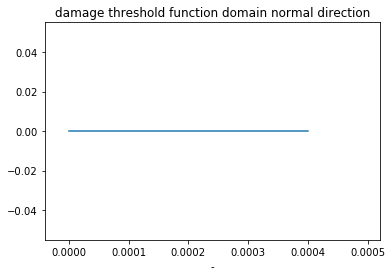

In [37]:
epsilon_0=2e-3
E_N=200
Y_0= 0.5 * E_N* epsilon_0**2
print(Y_0)
f=np.linspace(0,Y_0,30)
y=np.zeros_like(f)
plt.xlim(-Y_0*0.1,Y_0*1.3)
plt.plot(f,y)
plt.xlabel('-')
plt.title('damage threshold function domain normal direction')

Text(0.5,1,'stress-strain')

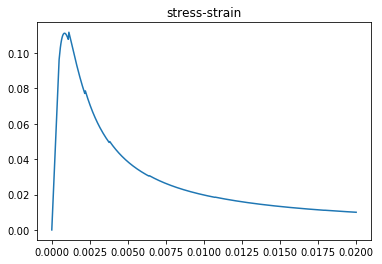

In [38]:
epsilon_0=0.0005
E_N=200.
A_d=10000.
eps=np.array(np.linspace(0,0.02,500))
t=np.arange(len(eps))
f_n=np.zeros_like(eps)
f_n_trial=np.zeros_like(eps)
psi_n=np.zeros_like(eps)
lambda_n=np.zeros_like(eps)
D_int=np.zeros_like(eps)
omega_n=np.zeros_like(eps)
sigma=np.zeros_like(eps)
r_n=np.zeros_like(eps)
Y_n=np.zeros_like(eps)
R_n=np.zeros_like(eps)


Y_0= 0.5 * E_N* epsilon_0**2
for i in range(1,len(eps)):
    #print(i)
    omega_n[i]=omega_n[i-1]
    r_n[i]=r_n[i-1]
    
    sigma[i] = (1.-omega_n[i])* E_N*(eps[i])
    Y_n[i]=0.5*E_N*eps[i]**2
    R_n[i]=(1./A_d)*(-r_n[i])/(1+r_n[i])
    
    f_n_trial[i]=Y_n[i]-(Y_0+R_n[i])
    #print(f_n[i])
    #f_n[i]=Y_n[i]-(Y_0)
                
    if f_n_trial[i] > 1e-9:
                
        #lambda_n[i]=1.-1./(1.+A_d*(Y_n[i]-Y_0))
        lambda_n[i]= A_d*E_N*eps[i]*(eps[i]-eps[i-1])/(t[i]-t[i-1])*(r_n[i]+1)**2
        omega_n[i]=omega_n[i]+lambda_n[i]
        r_n[i] = r_n[i] -lambda_n[i]
                
        sigma[i] = (1.-omega_n[i])* E_N*(eps[i])
        R_n[i]=(1./A_d)*(-r_n[i])/(1+r_n[i])
        
    
        
        #f_n[i]=Y_n[i]-(Y_0)
        #print(f_n[i])
    if omega_n[i]>1:
        print('limit reached')
        break
        
    f_n[i]=Y_n[i]-(Y_0+R_n[i])    
    psi_n[i]=0.5*(1.-omega_n[i])*E_N*(eps[i])**2+((-r_n[i]+np.log(1+r_n[i]))/A_d)
    #psi_n[i]=0.5*(1.-omega_n[i])*E_N*(eps[i])**2
    D_int[i]=Y_n[i]*lambda_n[i]
    
plt.subplot(111)
plt.plot(eps,sigma)
plt.title('stress-strain')

Text(0.5,1,'free energy-strain')

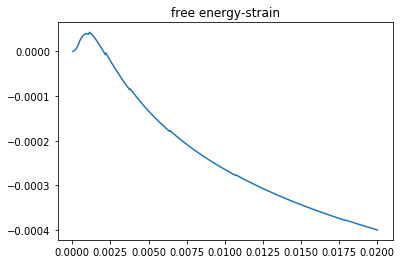

In [39]:
plt.subplot(111)
plt.plot(eps[1::],psi_n[1::])  
plt.title('free energy-strain')

Text(0.5,1,'damage-strain')

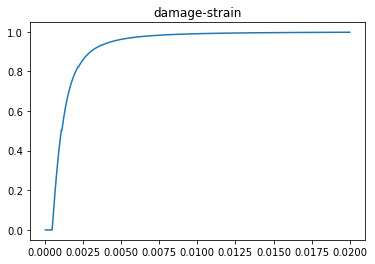

In [40]:
plt.subplot(111)
plt.plot(eps[1::],omega_n[1::])  
plt.title('damage-strain')

Text(0.5,1,'threshold-strain')

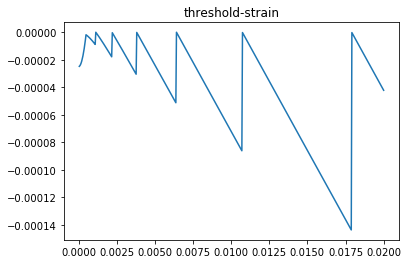

In [41]:
plt.subplot(111)
plt.plot(eps[1::],f_n[1::])        
plt.title('threshold-strain')

Text(0.5,1,'energy release-strain')

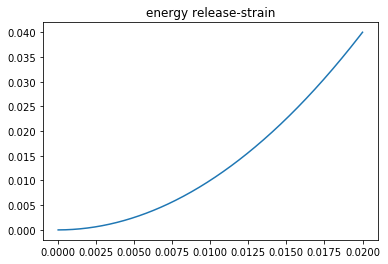

In [42]:
plt.subplot(111)
plt.plot(eps[1::],Y_n[1::]) 
plt.title('energy release-strain')

Text(0.5,1,'damage threshold function domain normal direction')

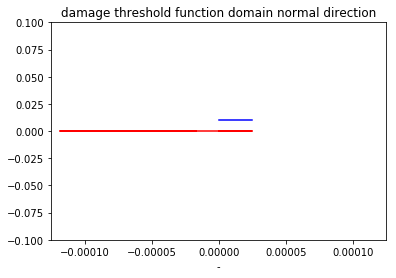

In [43]:
plt.subplot(111)

f=np.linspace(0,Y_0, len(Y_n))
y=np.zeros_like(f)
plt.xlim(-Y_0*5,Y_0*5)
plt.ylim(-0.1,0.1)
plt.plot(f,y+0.01,'b')
plt.plot(Y_n-R_n,y,'r')
plt.xlabel('-')
plt.title('damage threshold function domain normal direction')

### Microplane constitutive law tangential direction

In this model the thermodynamic potential for the tangential state variables associated to the microplane is given as

\begin{equation} \rho \psi^{mic}_{T} = \frac{1}{2} (1-\omega_T) E_T \mathbf{\varepsilon_T} \cdot \mathbf{\varepsilon_T} \end{equation}

thermodynamic forces

\begin{equation} \mathbf{\sigma_T} = \frac{\partial\rho\psi_T}{\partial\mathbf{\epsilon_T}} = (1-\omega_T) E_T \mathbf{\varepsilon_T}  \end{equation}

\begin{equation} \mathbf{\tilde{\sigma}_T} = \frac{\mathbf{\sigma_T}}{1-\omega_T}  \end{equation}

\begin{equation} Y_T= \frac {\partial \rho \psi_{T}}{\partial \omega_T} = \frac{1}{2} E_T \mathbf{\varepsilon_T}  \cdot \mathbf{\varepsilon_T} \end{equation}

The threshold fnction $f_T$ is used as a potential from which the plastic evolution equations of the model are derived

\begin{equation} f_T = ||\mathbf{\tilde{\sigma}_T}||-\sigma_T^0 \leq 0 \end{equation}


The non-associative flow potential defined as

\begin{equation} \phi_T = f_T + \frac{S(1-\omega_T)^c}{(r+1)} \left( \frac {\sigma_T^0}{\sigma_T^0-a\sigma_N} \right) \left( \frac {Y_T}{S} \right)^{r+1}\leq 0 \end{equation}

Loading / unloading conditions

\begin{equation} \phi_T \leq 0, \quad \dot{\lambda} \geq 0, \quad \dot{\lambda}\phi_T = 0\end{equation} 

The evolution laws

\begin{equation} \dot{\omega}_T = \dot{\lambda}^{\pi}_T \frac{\partial\phi_T}{\partial{Y_T}} =\dot{\lambda}^{\pi}_T (1-\omega_T) \left( \frac {\sigma_T^0}{\sigma_T^0-a\sigma_N} \right) \left( \frac {Y_T}{S} \right)^{r} \end{equation}

By differentiating the flow potential towards time and i ntroducing the last equation, it is possible to obtain the expression for the plastic multiplier $\dot{\lambda_T}$

\begin{equation} \dot{\phi}_T  = \mathbf{\dot{\tilde\sigma}_T} \frac{\partial\phi_T}{\partial\mathbf{\tilde{\sigma}_T}} + \dot{\omega}_T \frac{\partial\phi_T}{\partial\omega_T} + \dot{Y}_T \frac{\partial\phi_T}{\partial{Y_T}} = 0 \end{equation}

\begin{equation} \dot{\lambda}_T^{\pi} = \frac{E_T\mathbf{\dot{\varepsilon}_T}  \cdot \mathbf{\tilde{\sigma}_T}/||\mathbf{\tilde{\sigma}_T||}}{E_T/(1-\omega_T)} \end{equation}

The disspation inequality, in terms of Clausius-Duhem inequaluty reads:

\begin{equation} D_{int} = -\dot{\psi}_T + \mathbf{\sigma_T} \mathbf{\dot{\varepsilon}_T} \geq 0  \end{equation}



\begin{equation} D_{int} = -\left( \frac{\partial\psi_T}{\partial\mathbf{\varepsilon_T}} \mathbf{\dot{\varepsilon}_T} -\frac{\partial\psi_T}{\partial\omega_T} \dot{\omega}_T \right)  + \mathbf{\sigma_T} \mathbf{\dot{\varepsilon}_T} \geq 0  \end{equation}


\begin{equation} D_{int} = \left(\mathbf{\sigma_T}\ - \frac{\partial\psi_T}{\partial\mathbf{\varepsilon_T}} \right) \mathbf{\dot{\varepsilon}_T} + \frac{\partial\psi_T}{\partial\omega_T}\dot{\omega}_T \geq 0  \end{equation}



The inequality must be valid for arbitrary thermodynamic processes, i. e., for arbitrary $\dot{\varepsilon}_T$

\begin{equation} \frac{\partial\psi_T}{\partial\mathbf{\varepsilon_T}}  =\mathbf{\sigma_T} \end{equation}




So that the remaining disspitaion inequality remains as

\begin{equation} D_{rem} = Y_T\dot{\omega}_T \geq 0  \end{equation}

Which is fulfilled, as 

\begin{equation} \dot{\omega}_T = \dot{\lambda}^{\pi}_T (1-\omega_T) \left( \frac {Y_T}{S} \right)^{r} \geq 0 \end{equation}

as $\dot{\lambda}^{\pi}_T \geq 0, w_T \leq 1$, and 

\begin{equation} Y_T = \frac{1}{2} E_T \mathbf{\varepsilon_T}  \cdot \mathbf{\varepsilon_T} \geq 0 \end{equation}



With the porpouse of displaying the domain of the flow potential in a 2D space, the thermodynamical force $Y_T$ could be rewritten as

\begin{equation} Y_T = \frac{1}{2 E_T} \mathbf{\tilde{\sigma}_T}  \cdot \mathbf{\tilde{\sigma}_T} \end{equation}

And the flow potential as 

\begin{equation} \phi_T = ||\mathbf{\tilde{\sigma}_T}||-\sigma_T^0 + \frac{S(1-\omega_T)^c}{(r+1)} \left( \frac {\sigma_T^0}{\sigma_T^0-a\sigma_N} \right) \left( \frac {\mathbf{\tilde{\sigma}_T}  \cdot \mathbf{\tilde{\sigma}_T}}{S 2 E_T} \right)^{r+1} \end{equation}



Setting, $c, r = 1 $, $a = 0$, $E_T = 200$ , $S = 0.001$ and $\sigma_T^0 = 2$

\begin{equation} \phi_T = ||\mathbf{\tilde{\sigma}_T}||-2 + 5e^{-4}(1-\omega_T) \left( \frac {||\mathbf{\tilde{\sigma}_T}||^2}{0.4} \right)^2 \end{equation}

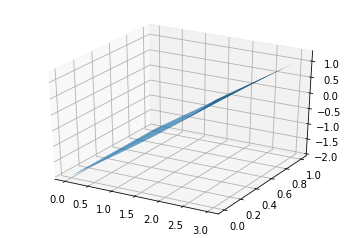

In [44]:
sigma_0=2.
E_T=200.
c=1.
r=1.
a=0.
S=0.001

fig = plt.figure()
ax = fig.gca(projection='3d')

abs_sig = np.linspace(0, 3, 100)
omega_T = np.linspace(0, 1, 100)

abs_sig, omega_T = np.meshgrid(abs_sig, omega_T)

phi_T= abs_sig - sigma_0 + (S*(1-omega_T)/(r+1))*(((abs_sig)**2)/(2*S*E_T))**(r+1) 

surf = ax.plot_surface(abs_sig, omega_T, phi_T)

plt.show()


[[0.]
 [0.]]


Text(0.5,1,'stress-strain')

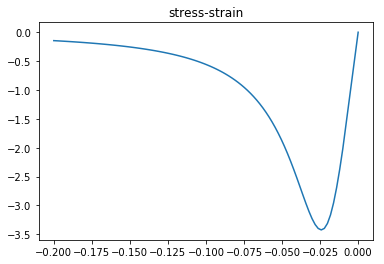

In [45]:
E_T=200.
sigma_0=2.
c=1.
r=1.
a=0.
S=0.001

eps_aux=np.linspace(0,-0.2,100)
eps=np.zeros((100,2,1))
print(eps[25])
eps[:,0,0]=eps_aux[:]
phi_t=np.zeros_like(eps_aux)
omega_T=np.zeros_like(eps_aux)
Y_T=np.zeros_like(eps_aux)
psi_t=np.zeros_like(eps_aux)
lambda_t=np.zeros_like(eps_aux)
D_int=np.zeros_like(eps_aux)
sigma=np.zeros_like(eps)
sigma_tilde=np.zeros_like(eps)

for i in range(1,len(eps_aux)):
    omega_T[i]=omega_T[i-1]
    sigma[i]=(1.-omega_T[i])* E_T*eps[i]
    sigma_tilde[i] = E_T*eps[i]
    Y_T[i]=0.5*E_T*np.einsum('i...,i...->...',eps[i],eps[i])
    phi_t[i]=np.linalg.norm(sigma_tilde[i])-sigma_0+S*((1.-omega_T[i])**c)/(r+1.)*(Y_T[i]/S)**(r+1)
    if phi_t[i] > 0:
        lambda_t[i]=(E_T*np.einsum('i...,i...->...',(eps[i]-eps[i-1]),sigma_tilde[i])/np.linalg.norm(sigma_tilde[i]))/(E_T/(1- omega_T[i]))
        omega_T[i]=omega_T[i]+((1-omega_T[i])**c)*((Y_T[i]/S)**r)*lambda_t[i]
        phi_t[i]=np.linalg.norm(sigma_tilde[i])-sigma_0+S*((1.-omega_T[i])**c)/(r+1.)*(Y_T[i]/S)**(r+1)  
    psi_t[i]=0.5*(omega_T[i])*E_T*np.einsum('i...,i...->...',eps[i],eps[i])
    D_int[i]=D_int[i-1]+Y_T[i]*((1-omega_T[i])**c)*((Y_T[i]/S)**r)*lambda_t[i]
    
plt.subplot(111)
plt.plot(eps[:,0,0],sigma[:,0,0])
plt.title('stress-strain')

Text(0.5,1,'flow potential-strain')

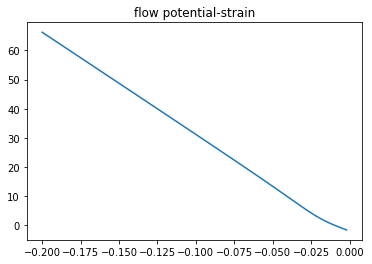

In [46]:
plt.subplot(111)
plt.plot(eps[1::,0,0],phi_t[1::])        
plt.title('flow potential-strain')

Text(0.5,1,'free energy-strain')

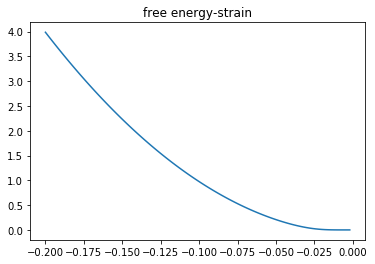

In [47]:
plt.subplot(111)
plt.plot(eps[1::,0,0],psi_t[1::])  
plt.title('free energy-strain')

Text(0.5,1,'damage-strain')

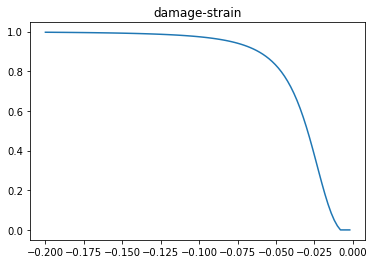

In [48]:
plt.subplot(111)
plt.plot(eps[1::,0,0],omega_T[1::])  
plt.title('damage-strain')

Text(0.5,1,'entropy-strain')

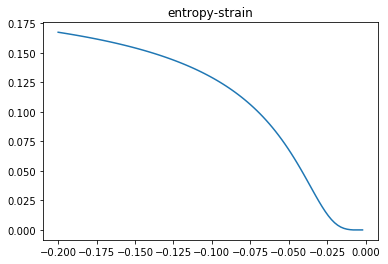

In [49]:
plt.subplot(111)
plt.plot(eps[1::,0,0],D_int[1::]) 
plt.title('entropy-strain')

Text(0.5,1,'yielding function domain tangental direction')

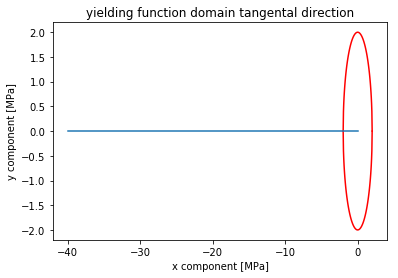

In [50]:
plt.subplot(111)
sigma_t_x=np.linspace(-sigma_0,sigma_0,100)
sigma_t_y= np.sqrt(sigma_0**2 - sigma_t_x**2)
#sigma_t_x= np.concatenate((sigma_t_x,sigma_t_x))                          
plt.plot(sigma_t_x,sigma_t_y,'r')
plt.plot(sigma_t_x,-sigma_t_y,'r')
plt.plot(sigma_tilde[:,0,0],sigma_tilde[:,1,0])
plt.xlabel('x component [MPa]')
plt.ylabel('y component [MPa]')
plt.title('yielding function domain tangental direction')